# Fitting Analysis, post FFTS


To begin we need to load in the data that we want to fit. Load in all of the FFTs for the condition that will be analyzed. We will then average the ROIs for the condition and then find the diffusion coefficient for each of the averaged ROI regions.


In [1]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

import mpld3

C:\Users\Physics\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [173]:
allResults = {}

In [125]:
Sample = ['0.02mgmlDNA_Buffer_17.5fps_55exp_8000frames', '0.02mgmlDNA_Buffer_49fps_20exp_8000frames','0.02mgmlDNA_Buffer_99fps_10exp_8000frames','0.02mgmlDNA_Buffer_99fps_10exp']

In [318]:
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 49.0
px = 0.189
imDimension = 128

In [317]:
# different ROIs and the video number, change samNumber based upon the number of videos taken for the condition
ROI = ['0', '128', '256', '384', '512', '640', '768', '896']
samNumber = ['1','2','3','4','5','6','7','8']
num = 1

Check the ffts, if they look weird, skip that ROI and move on to a different one, probably stick with the middle to right hand ROIs, 384 onwards for some of the samples at least.

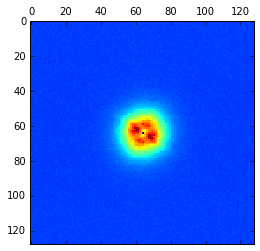

In [384]:
%matplotlib inline
mpld3.enable_notebook()
# Change the directory or data file and change the condition number so the average ROI list can be iterated over
ss = 0 #changes the video
c = 7 #changes the ROI

data_dir = "Z:\\Devynn_Summer2018\\Data\\2018-06-01_DNA\\AllVideos\\"

data_file = Sample[num]+"_"+samNumber[ss]+"_MMStack_Pos0.ome_"+ROI[c]+"_BH_128x128_FFTDIFFS_dts_ravs.p"

dat = pickle.load(open(data_dir + data_file,'r'))
ravs = dat['ravs'] 
dts  = dat['dts']
ffts = dat['ffts']

#plt.matshow(ffts[5])
plt.matshow(ffts[10])
#plt.matshow(ffts[25])

In [353]:
#reload(ddm)

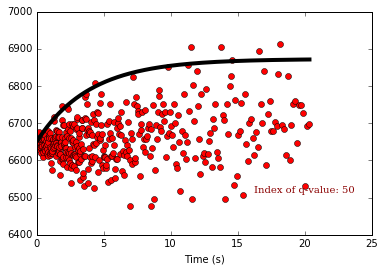

In [386]:
%matplotlib inline
mpld3.enable_notebook()

q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*px*2))
times = dts/framerate
q_index = 50
backg = 6650
#We try to use the function `returnReasonableParams` to find reasonable initial guesses for the fitting function

pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=ravs[:,q_index],bg=backg, double=False, fps=framerate)
plt.plot(times, ravs[:,q_index],'ro') #plot the data
plt.plot(times, ddm.dTheory(times,*pars), '-k', lw=4) #see how well the initial guess performs
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % q_index, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)');

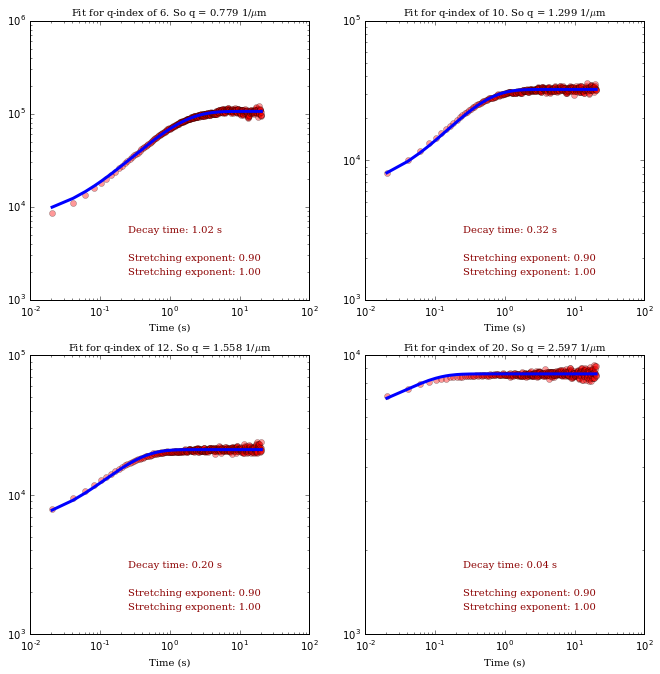

In [388]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''
    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=backg, double=False, fps=framerate)
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp), (... same for second exp..))
    
    minp[3]=0.9
    maxp[3]=1.0
    maxp[2]=7000
    minp[2]=6000
    pars[3]=1.0
    maxp[1] = 100
    maxp[5] = 100
    fix[2]=False
    fix[3]=False
    minp[6] = 0.5
    maxp[6]=1.0

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

plt.figure(figsize=(11,11)) #Create figure of size 15x15 (inches)

#Loop over four different q-values to do the fit
for i,q_index in enumerate([6,10,12,20]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:,q_index], times)
    ax = plt.subplot(2,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.loglog(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times, theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.15,'Stretching exponent: %.2f' % fitparamsB[3], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.10,'Stretching exponent: %.2f' % fitparamsB[6], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)

In [389]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
amp2 = np.zeros_like(tau) #amplitude
tau2 = np.zeros_like(tau) #background
alph2 = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fitparams, theory, chi2 = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[0]
    bg[i] = fitparams[2]
    tau[i] = fitparams[1]
    alph[i] = fitparams[3]
    amp2[i] = fitparams[4]
    tau2[i] = fitparams[5]
    alph2[i] = fitparams[6]

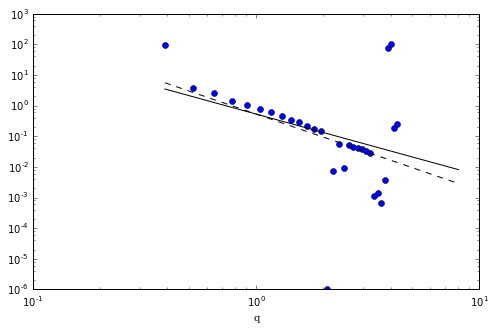

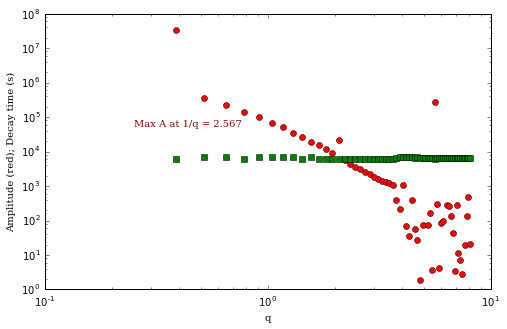

In [390]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
#ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-30], ddm.newt(tau[2:-30],alph[2:-30]),'bo')
#ax.loglog(q[3:-30], ddm.newt(tau2[2:-30],alph2[2:-30]),'rv')
diffusion_coeff = 1.9
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
adiffusion_coeff = 1.9
ax.plot(q[3:-1], (1./adiffusion_coeff) * 1./(q[3:-1]**2.5), '--k')
ax.set_xlabel("q", fontdict=font_plt_ax)


#Plot the amplitude versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], amp[2:-1], 'ro')
#ax.loglog(q[3:-1], amp2[2:-1], 'rv')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[3:-1][w]
ax.loglog(q[3:-1], bg[2:-1], 'gs') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)
ax.text(0.2,0.6,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);

In [391]:
allResults['fitparams'+ROI[c]] = fitparams
allResults['theory'+ROI[c]] = theory
allResults['chi2'+ROI[c]] = chi2

In [392]:
pickle.dump(allResults, open('Z:\\Devynn_Summer2018\\Data\\2018-06-01_DNA\\AllVideos\\allResults\\allResults_'+Sample[num]+'_'+samNumber[ss]+'.p', 'wb'))
allResults = {}

In [793]:
def DiffCoef (tau, StretchExp, qrange, qmin, qmax):
    nt = ddm.newt(tau, StretchExp)
    indx = (qrange>qmin) & (qrange<qmax)
    ds = (qrange[indx]**-2) / nt[indx]
    return ds.mean()

def Diff_Fit(qrange, taurange, qmin, qmax, StExp):
    step1 = DiffCoef(taurange, StExp, qrange, qmin, qmax)
    fit1 = (1./step1) * 1./(qrange**2)
    return fit1, step1
    
#Need to fix the function so the it will fit the data
#define a function to plot the results

def plot_results(qmin = q[2], qmax = q[10]):
    qs = q[3:-1]
    taus = tau[2:-1]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    ax.loglog(qs, tau[2:-1], 'ro')
    ax.loglog(qs, ddm.newt(taus ,alph[2:-1]),'bo')
    fits = Diff_Fit(qs,taus, qmin, qmax, alph[2:-1])
    ax.plot(qs, fits[0],  '-k')
    ax.text(0.55,0.8,'D = %.2f' %fits[1], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)

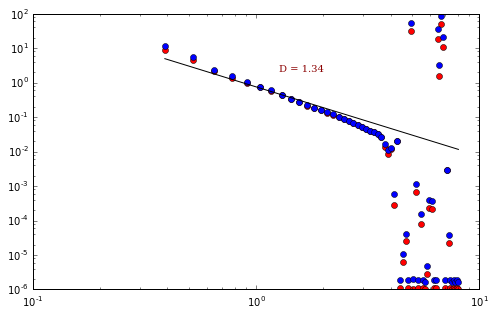

In [794]:
interact(plot_results, qmin = (q[2], q[8]), qmax = (q[9], q[20]), continuous_update=False)

In [380]:
step2 = ddm.getDiff(q[3:-1], tau[2:-1], qmin=q[9], qmax=q[20])
a = np.polyfit(q[3:-1], tau[2:-1], 2)
print(step2, a)
1/step2[1]

(array([ 0.15434115,  0.86212963]), array([  0.14701085,   9.19390958, -11.33062203]))


1.1599183804225213

In [366]:
w = np.where((q>0.4)&(q<3))
a = w[0]
print a

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [86]:
# Saving the data into the pickle file
AvgROIs['bestfitparms_ROI'+con[0]] = fitparams
AvgROIs['bestfitDiffCoef_ROI'+con[0]] = 0 #enter in the value after fitting the diffusion coefficient

In [ ]:
# Do once you have averaged and fit all of the ROIs for the condition 
#pickle.dump(AvgROIs, open('ROIResults_'+Sample[0]+'.p', 'wb'))
#Just seeing what happens if I add something, trying to figure out github